# 5. Time series regression

Qinghai University for Nationalities, *Python Data Analysis in Finance* course, machine learning part.

Author: *cloudy-sfu*

In [2]:
# Only in Google Colab
import os

_ = os.system("""if [ ! -f apple.csv ]; then 
    wget https://github.com/cloudy-sfu/QUN-data-analysis-in-finance/raw/main/Labs/data/apple.csv 
fi""")

Load the packages.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data pre-processing

Read the dataset.

In [4]:
apple = pd.read_csv("apple.csv")

In [ ]:
apple.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2006-10-02,10.728572,10.838572,10.614285,10.694285,7.239566,178159800
1,2006-10-03,10.635715,10.707143,10.455714,10.582857,7.164135,197677200
2,2006-10-04,10.585714,10.780000,10.451428,10.768572,7.289855,207270700
3,2006-10-05,10.647142,10.880000,10.590000,10.690000,7.236666,170970800
4,2006-10-06,10.631429,10.720000,10.544286,10.602858,7.177672,116739700


**Rate of return:**

Predicting the close price is meaningless, because the change of price in each trading day is always small compared to the absolute value of price. We may reach a very low MSPE, however it's not the case in real world: we repeat buy and sell the asset, and only the rate of return instead of the price will determine how much our porfolio grows.

Therefore, we make a dataset to use the rate of return and volume of each day $T$ to predict the rate of return of the day $T+1$.

**Volume:**

In the real world, people are more sentative to the change of rate instead of change of value. For example, the sell amount A goes from 10 to 11, B goes from 1000 to 1100, C goes from 1000 to 1010. People will say A and B have the same performance, and C is worse.

Therefore, we take its logarithmic value, because it can uniformly represent the difference of popularity in trading according to the analysis above.

In [5]:
idx = pd.to_datetime(apple['Date'][1:]).values
ts = np.vstack([
    np.diff(np.log(apple['Adj Close'])),
    np.log(apple['Volume'][1:]),
]).T

Split into the training and testing set. Because one data point can be affected by the previous values in the same time series, we should not shuffle.

In [6]:
from sklearn.model_selection import train_test_split

idx_train, idx_test, ts_train, ts_test = train_test_split(idx, ts, train_size=0.8, shuffle=False)

Perform standardization.

In [7]:
from sklearn.preprocessing import StandardScaler

ts_scaler = StandardScaler()
ts_train_std = ts_scaler.fit_transform(ts_train)
ts_test_std = ts_scaler.transform(ts_test)

y_scaler = StandardScaler()
y_scaler.fit(ts_train[:, 0:1])

StandardScaler()

Convert the time series to cross-sectional dataset.

In [8]:
def moving_window(ts, k):
    """
    Make moving window samples from time series.
    :param ts: Time series.
    :param k: Length of the window.
    :return: x_, y_: fraction used as input, fraction used as output.
    """
    l = ts.shape[0]
    y_ = ts[k:]
    indices = np.tile(np.arange(k), [l-k, 1]) + np.arange(l-k)[:, np.newaxis]
    x_ = ts[indices]
    return x_, y_

In [9]:
lag = 10
_, idx_train = moving_window(idx_train, lag)
x_train_std, y_train_std = moving_window(ts_train_std, lag)
y_train_std = y_train_std[:, 0:1]  # predict only the standardized rate of return
_, idx_test = moving_window(idx_test, lag)
x_test_std, y_test_std = moving_window(ts_test_std, lag)
y_test_std = y_test_std[:, 0:1]
y_test = y_scaler.inverse_transform(y_test_std)

Check the dimension of dataset.

In [10]:
x_train_std.shape, y_train_std.shape, x_test_std.shape, y_test_std.shape

((2254, 10, 2), (2254, 1), (557, 10, 2), (557, 1))

In [11]:
idx_train.shape, idx_test.shape

((2254,), (557,))

In some models, we should use 2-dimensional dataset: the time axis and attribute axis are melted as one.

In [12]:
x_train_std_melted = np.reshape(np.transpose(x_train_std, (0, 2, 1)), (x_train_std.shape[0], -1))
x_test_std_melted = np.reshape(np.transpose(x_test_std, (0, 2, 1)), (x_test_std.shape[0], -1))

Check the dimension of melted dataset.

In [13]:
x_train_std_melted.shape, x_test_std_melted.shape

((2254, 20), (557, 20))

## Linear autoregression

The major difference between autoregression and regression is, the variables (columns) of autoregression are dependent. Pracitcally, we can still use `LinearRegression` as we used in cross-sectional regression.

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train_std_melted, y_train_std)

LinearRegression()

Evaluate the model.

In [ ]:
from sklearn.metrics import r2_score

y_test_std_hat_lr = lr.predict(x_test_std_melted)
y_test_hat_lr = y_scaler.inverse_transform(y_test_std_hat_lr)
r2_score(y_test, y_test_hat_lr)

-0.023349749311035728

Visualize the prediction.

In [ ]:
idx_test.shape

(557,)

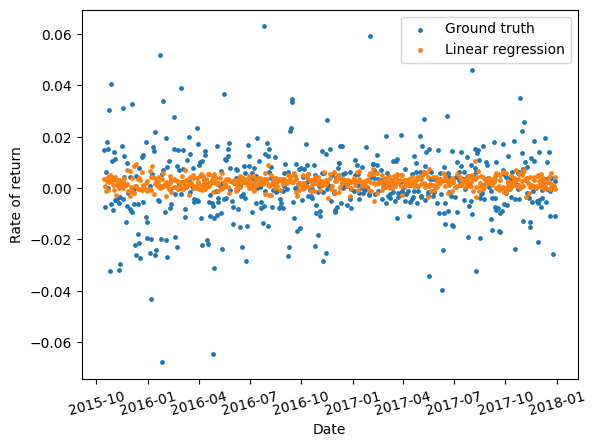

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(idx_test, y_test, label='Ground truth', s=6)
ax.scatter(idx_test, y_test_hat_lr, label='Linear regression', s=6)
ax.legend()
ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=15)
ax.set_xlabel('Date')
ax.set_ylabel('Rate of return')
fig.show()

## Lasso regression

$$
\mathcal{L} = {1\over2N} \lVert y - Xw \rVert_2 +
L_1 \lVert w \rVert_1
$$

In [ ]:
from sklearn.linear_model import LassoCV

lasso = LassoCV()
lasso.fit(x_train_std_melted, y_train_std.ravel())

LassoCV()

In [ ]:
from sklearn.metrics import r2_score

y_test_std_hat_lasso = lasso.predict(x_test_std_melted)[:, np.newaxis]
y_test_hat_lasso = y_scaler.inverse_transform(y_test_std_hat_lasso)
r2_score(y_test, y_test_hat_lasso)

-0.0006428265628859453

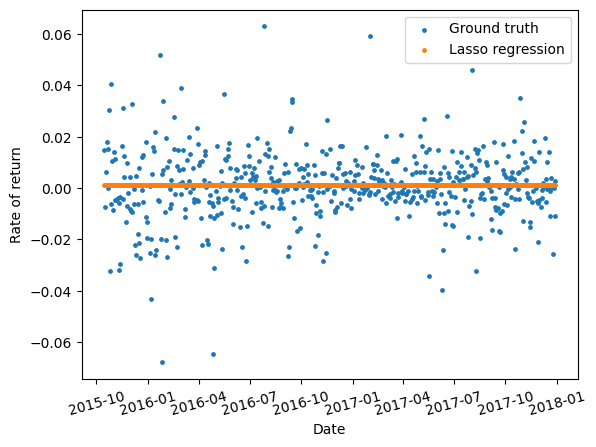

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(idx_test, y_test, label='Ground truth', s=6)
ax.scatter(idx_test, y_test_hat_lasso, label='Lasso regression', s=6)
ax.legend()
ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=15)
ax.set_xlabel('Date')
ax.set_ylabel('Rate of return')
fig.show()

## Ridge regression

$$
\mathcal{L} = {1\over2N} \lVert y - Xw \rVert_2 +
L_2 \lVert w \rVert_2
$$

In [ ]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV()
ridge.fit(x_train_std_melted, y_train_std.ravel())

RidgeCV()

In [ ]:
from sklearn.metrics import r2_score

y_test_std_hat_ridge = ridge.predict(x_test_std_melted)[:, np.newaxis]
y_test_hat_ridge = y_scaler.inverse_transform(y_test_std_hat_ridge)
r2_score(y_test, y_test_hat_ridge)

-0.022115914926959634

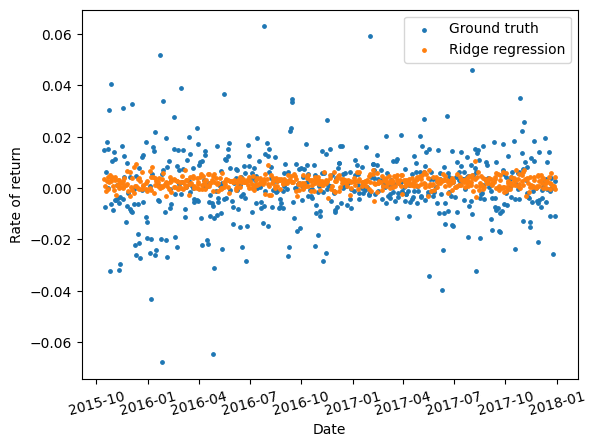

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(idx_test, y_test, label='Ground truth', s=6)
ax.scatter(idx_test, y_test_hat_ridge, label='Ridge regression', s=6)
ax.legend()
ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=15)
ax.set_xlabel('Date')
ax.set_ylabel('Rate of return')
fig.show()

## Elastic Net

$$
\mathcal{L} = {1\over2N} \lVert y - Xw \rVert_2 +
L_1 \lVert w \rVert_1 + 
L_2 \lVert w \rVert_2
$$

In [ ]:
from sklearn.linear_model import ElasticNetCV

elastic_net = ElasticNetCV()
elastic_net.fit(x_train_std_melted, y_train_std.ravel())

ElasticNetCV()

In [ ]:
from sklearn.metrics import r2_score

y_test_std_hat_elastic_net = elastic_net.predict(x_test_std_melted)[:, np.newaxis]
y_test_hat_elastic_net = y_scaler.inverse_transform(y_test_std_hat_elastic_net)
r2_score(y_test, y_test_hat_elastic_net)

-0.0006428265628859453

Watch the coefficients.

In [ ]:
l1 = elastic_net.alpha_ * elastic_net.l1_ratio_
l2 = elastic_net.alpha_ - l1
print('L1:', l1)
print('L2:', l2)

L1: 0.05549169107169152
L2: 0.05549169107169152


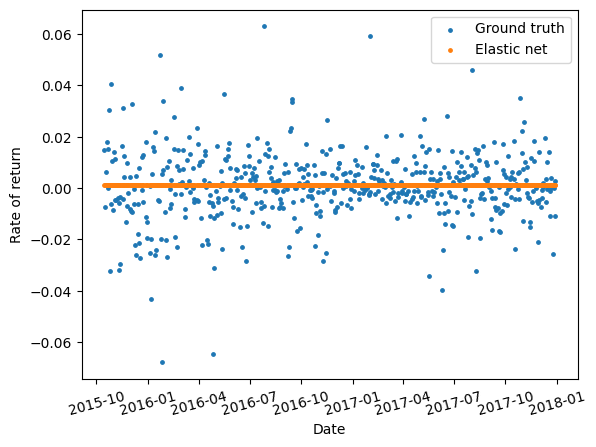

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(idx_test, y_test, label='Ground truth', s=6)
ax.scatter(idx_test, y_test_hat_elastic_net, label='Elastic net', s=6)
ax.legend()
ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=15)
ax.set_xlabel('Date')
ax.set_ylabel('Rate of return')
fig.show()

## Dense neural network

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import *

n_epochs = 200

l0 = Input(shape=(lag * 2,))
l1 = Dense(units=64, activation='relu')(l0)
l2 = Dense(units=64, activation='relu')(l1)
l3 = Dense(units=1, activation='linear')(l2)

dense = tf.keras.Model(l0, l3)
dense.compile(optimizer='adam', loss='mse')
dense_history = dense.fit(x_train_std_melted, y_train_std, epochs=n_epochs, batch_size=2300, 
                          validation_data=(x_test_std_melted, y_test_std), verbose=0)

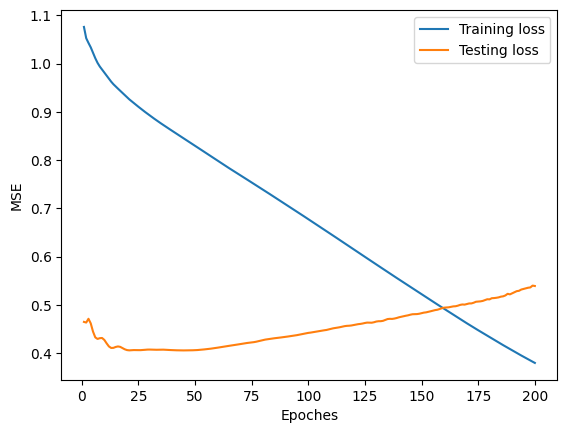

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(np.arange(1, n_epochs + 1), dense_history.history['loss'], label='Training loss')
ax.plot(np.arange(1, n_epochs + 1), dense_history.history['val_loss'], label='Testing loss')
ax.legend()
ax.set_xlabel('Epoches')
ax.set_ylabel('MSE')
fig.show()

In [39]:
from sklearn.metrics import r2_score

y_test_std_hat_dense = dense.predict(x_test_std_melted)
y_test_hat_dense = y_scaler.inverse_transform(y_test_std_hat_dense)
r2_score(y_test, y_test_hat_dense)

18/18 [==============================] - 0s 896us/step


-0.39238155508172

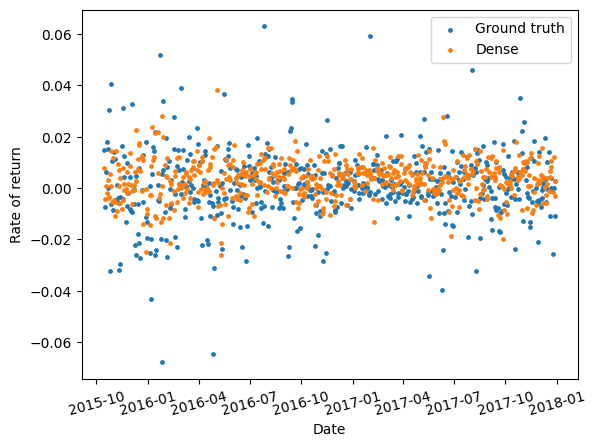

In [40]:
fig, ax = plt.subplots()
ax.scatter(idx_test, y_test, label='Ground truth', s=6)
ax.scatter(idx_test, y_test_hat_dense, label='Dense', s=6)
ax.legend()
ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=15)
ax.set_xlabel('Date')
ax.set_ylabel('Rate of return')
fig.show()

## Long-short Term Memory

In [42]:
import tensorflow as tf
from tensorflow.keras.layers import *

n_epoches = 500

l0 = Input(shape=(lag, 2))
l1 = LSTM(units=64)(l0)
l2 = Dense(units=64, activation='relu')(l1)
l3 = Dense(units=1, activation='linear')(l2)

lstm = tf.keras.Model(l0, l3)
lstm.compile(optimizer='rmsprop', loss='mse')
lstm_history = lstm.fit(x_train_std, y_train_std, epochs=n_epoches, batch_size=2300, 
                        validation_data=(x_test_std, y_test_std), verbose=0)

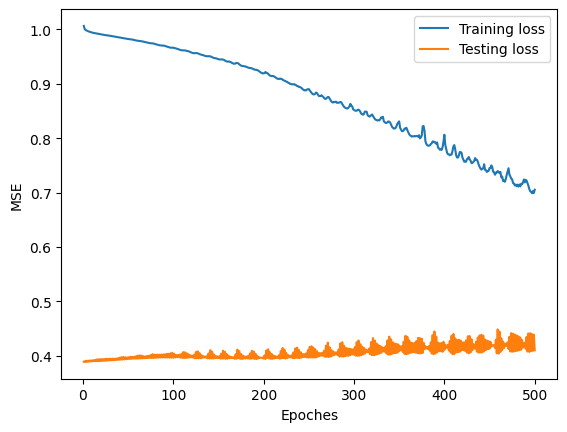

In [44]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, n_epoches + 1), lstm_history.history['loss'], label='Training loss')
ax.plot(np.arange(1, n_epoches + 1), lstm_history.history['val_loss'], label='Testing loss')
ax.legend()
ax.set_xlabel('Epoches')
ax.set_ylabel('MSE')
fig.show()

In [45]:
from sklearn.metrics import r2_score

y_test_std_hat_lstm = lstm.predict(x_test_std)
y_test_hat_lstm = y_scaler.inverse_transform(y_test_std_hat_lstm)
r2_score(y_test, y_test_hat_lstm)

18/18 [==============================] - 0s 2ms/step


-0.05828669339317427

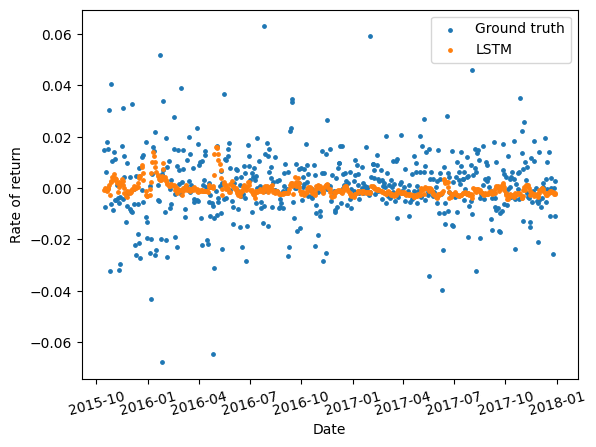

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(idx_test, y_test, label='Ground truth', s=6)
ax.scatter(idx_test, y_test_hat_lstm, label='LSTM', s=6)
ax.legend()
ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), rotation=15)
ax.set_xlabel('Date')
ax.set_ylabel('Rate of return')
fig.show()